<a href="https://colab.research.google.com/github/singhsidhukuldeep/Fraud-Prediction/blob/main/Financial_Payment_Services_Fraud_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading Data

In [1]:
%%shell
wget https://bitbucket.org/!api/2.0/snippets/singhsidhukuldeep/rXXG7o/7e66099bfc00fdb8141b9b31d32989fbfa2a74c9/files/transactions.csv.zip
unzip -o transactions.csv.zip
mv transactions.csv.zip transactions.csv
head -3 transactions.csv

--2021-09-26 14:14:17--  https://bitbucket.org/!api/2.0/snippets/singhsidhukuldeep/rXXG7o/7e66099bfc00fdb8141b9b31d32989fbfa2a74c9/files/transactions.csv.zip
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c2:513, 2406:da00:ff00::34cc:ea4a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183597220 (175M) [application/zip]
Saving to: ‘transactions.csv.zip’

transactions.csv.zi 100%[===================>] 175.09M  55.5MB/s    in 3.6s    

2021-09-26 14:14:27 (48.9 MB/s) - ‘transactions.csv.zip’ saved [183597220/183597220]

Archive:  transactions.csv.zip
  inflating: transactions.csv.zip    
step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0


## Importing modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost.sklearn import XGBClassifier
import seaborn as sb

from tqdm.auto import tqdm
tqdm.pandas()

!pip install -q pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

data_file_loc = 'transactions.csv'
debug = False
debug_size=0.1
test_train_size=0.3

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Opening dataset

In [3]:
df = pd.read_csv(data_file_loc)
if debug:
    print(f'>> Before debug {df.shape}')
    df,_ = train_test_split(df, stratify=df.isFraud, train_size=debug_size)
    df.reset_index(drop=True, inplace=True)
    print(f'>> After debug {df.shape}')
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


## Exploratory Data Analysis

In [4]:
# Null values and Duplicates check
df.isnull().values.any(), df.duplicated(df.columns[:-1]).values.any()

(False, False)

(0    6343476
 1       7717
 Name: isFraud, dtype: int64, 0    99.878495
 1     0.121505
 Name: isFraud, dtype: float64, <matplotlib.axes._subplots.AxesSubplot at 0x7f13aedf1310>)

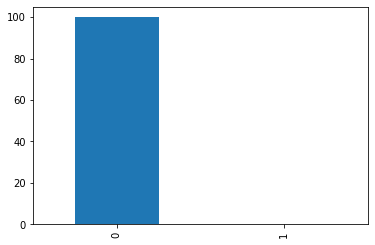

In [5]:
# Im-balance check
df.isFraud.value_counts(), df.isFraud.value_counts()*100/len(df), (df.isFraud.value_counts()*100/len(df)).plot.bar()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


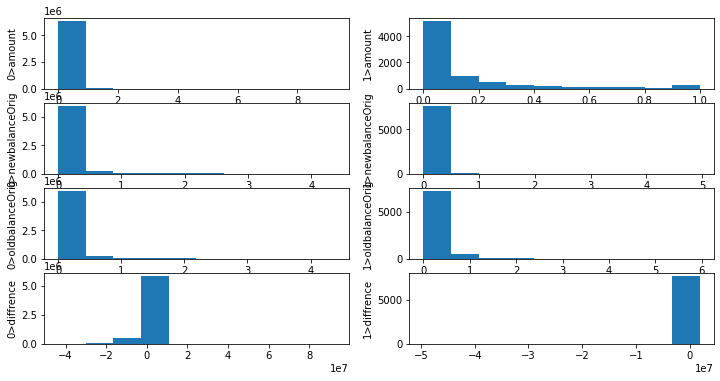

In [6]:
# value ditribution for fraud
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12,6))
for i,label in enumerate([0,1]):
    temp=df[df.isFraud==label]
    temp ['diffrence'] = temp.amount-temp.oldbalanceOrig
    for j,col in enumerate(['amount','newbalanceOrig','oldbalanceOrig','diffrence']):
        temp[col].plot.hist(ax = axes[j,i],subplots=True)
        plt.setp(axes[j,i], ylabel=f'{label}>{col}')

(isFraud  type    
 0        CASH_OUT    2229501
          PAYMENT     2147832
          CASH_IN     1396865
          TRANSFER     527968
          DEBIT         41310
 1        CASH_OUT       3868
          TRANSFER       3849
 dtype: int64, <matplotlib.axes._subplots.AxesSubplot at 0x7f13ae525ad0>)

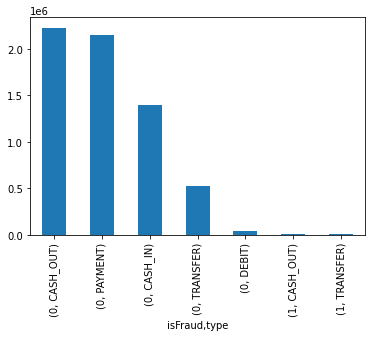

In [7]:
# type distribution
df[['isFraud','type']].value_counts(), df[['isFraud','type']].value_counts().plot.bar()

In [8]:
# are the frauds doing more transactions
print(df[df['isFraud']==1].duplicated('nameOrig').values.any(), df[df['isFraud']==1].duplicated('nameDest').values.any())
# are not frauds doing more transactions
print(df[df['isFraud']==0].duplicated('nameOrig').values.any(), df[df['isFraud']==0].duplicated('nameDest').values.any())

False True
True True


In [9]:
# checking if sequence occurs enough number of times to create a feature out of it
print(df.duplicated(['step','nameOrig', 'nameDest']).values.any(), df.duplicated(['amount','nameOrig', 'nameDest']).values.any(),)
print(df.duplicated(['nameOrig', 'nameDest']).values.any())
print(df.duplicated(['step','nameOrig']).values.any(), df.duplicated(['step','nameDest']).values.any())
print(df.duplicated(['amount','nameOrig']).values.any(), df.duplicated(['amount','nameDest']).values.any(), df.duplicated(['step','amount','nameDest']).values.any())
print(df.duplicated(['isFraud','step','nameOrig']).values.any(), df.duplicated(['isFraud','step','nameDest']).values.any(),df.duplicated(['isFraud','amount','nameDest']).values.any())

False False
False
True True
False True True
True True True


In [10]:
# checking flow of money
df['debit']=df.oldbalanceOrig - df.newbalanceOrig
df['credit']=df.newbalanceDest - df.oldbalanceDest
df['bal0Orig']=df.parallel_apply(lambda x: x.oldbalanceOrig==0 and x.newbalanceOrig==0, axis=1)
df['bal0Dest']=df.parallel_apply(lambda x: x.oldbalanceDest==0 and x.newbalanceDest==0, axis=1)
df['credit_error']=df.credit-df.amount
df['debit_error']=df.debit-df.amount
df=df.round(2)
df

   0.00%                                          |        0 /  3175597 |      
   0.00%                                          |        0 /  3175596 |      M   0.00%                                          |        0 /  3175597 |      
   1.00%                                          |    31755 /  3175596 |      M   1.00%                                          |    31755 /  3175597 |      
   1.04%                                          |    33055 /  3175596 |      M   1.04%                                          |    33011 /  3175597 |      
   1.38%                                          |    43705 /  3175596 |      M   1.32%                                

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,debit,credit,bal0Orig,bal0Dest,credit_error,debit_error
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,9839.64,0.00,False,True,-9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,1864.28,0.00,False,True,-1864.28,-0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,181.00,0.00,False,True,-181.00,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,181.00,-21182.00,False,False,-21363.00,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,11668.14,0.00,False,True,-11668.14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351188,699,TRANSFER,162326.52,C1557504343,162326.52,0.00,C404511346,0.00,0.00,1,162326.52,0.00,False,True,-162326.52,0.0
6351189,699,CASH_OUT,162326.52,C1532317723,162326.52,0.00,C446134087,0.00,162326.52,1,162326.52,162326.52,False,False,0.00,0.0
6351190,699,TRANSFER,2763398.31,C577803442,2763398.31,0.00,C619602282,0.00,0.00,1,2763398.31,0.00,False,True,-2763398.31,0.0
6351191,699,CASH_OUT,2763398.31,C1491503658,2763398.31,0.00,C454424230,339515.35,3102913.66,1,2763398.31,2763398.31,False,False,0.00,0.0


In [12]:
grouped_temp = df[['step','amount','nameDest']].value_counts().to_dict()
df['step_amnt_nDst_cnt']=df.progress_apply(lambda x: grouped_temp[(x.step,x.amount,x.nameDest)], axis=1)

  0%|          | 0/6351193 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Heat Map')

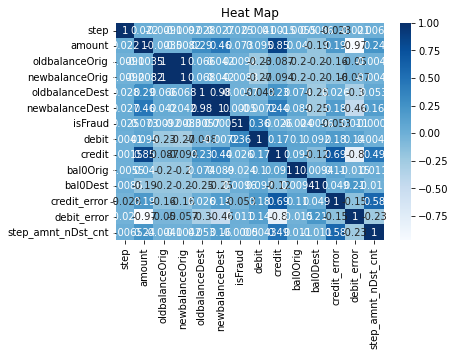

In [13]:
corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True).set_title('Heat Map')

Text(0.5, 1.0, 'Fraud')

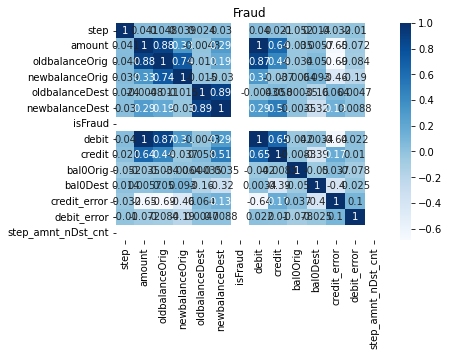

In [14]:
corr = df[df['isFraud']==1].corr()
sb.heatmap(corr, cmap="Blues", annot=True).set_title('Fraud')

Text(0.5, 1.0, 'Not Fraud')

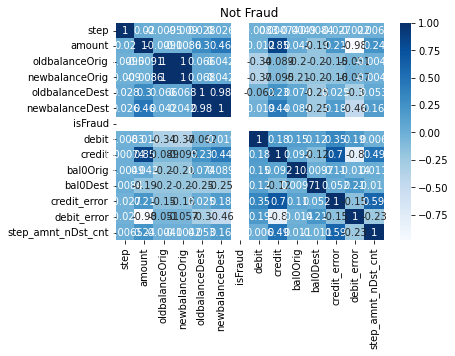

In [15]:
corr = df[df['isFraud']==0].corr()
sb.heatmap(corr, cmap="Blues", annot=True).set_title('Not Fraud')

## Processing

In [16]:
df = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])]
df['type_encoded']=df.progress_apply(lambda x: 1 if x.type=='CASH_OUT' else 0, axis=1)
X = df[[_ for _ in list(df.columns) if _ not in ['isFraud','nameOrig','nameDest','type']]]
Y = df['isFraud']
trainX, testX, trainY, testY = train_test_split(X, Y, stratify=Y, train_size=test_train_size)

  0%|          | 0/2765186 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Training

In [17]:
%%time
clf = XGBClassifier(
    max_depth = 3, 
    scale_pos_weight = trainY.count()/trainY.sum(), 
    n_jobs = 4)
model = clf.fit(trainX, trainY)

CPU times: user 2min 19s, sys: 360 ms, total: 2min 19s
Wall time: 1min 13s


## Testing

In [18]:
testX.columns

Index(['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'debit', 'credit', 'bal0Orig', 'bal0Dest',
       'credit_error', 'debit_error', 'step_amnt_nDst_cnt', 'type_encoded'],
      dtype='object')

In [19]:
print(classification_report(testY, model.predict(testX)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1930229
           1       1.00      0.99      1.00      5402

    accuracy                           1.00   1935631
   macro avg       1.00      1.00      1.00   1935631
weighted avg       1.00      1.00      1.00   1935631



## Predictions

In [20]:
def transform(step, 
              type, 
              amount, 
              nameOrig, 
              oldbalanceOrig, 
              newbalanceOrig, 
              nameDest, 
              oldbalanceDest, 
              newbalanceDest):
    return [
            {
                'step':step,
                'amount':amount,
                'oldbalanceOrig':oldbalanceOrig,
                'newbalanceOrig':newbalanceOrig,
                'oldbalanceDest':oldbalanceDest,
                'newbalanceDest':newbalanceDest,
                'debit':oldbalanceOrig - newbalanceOrig,
                'credit':newbalanceDest - oldbalanceDest,
                'bal0Orig':oldbalanceOrig==newbalanceOrig==0,
                'bal0Dest':oldbalanceDest==newbalanceDest==0,
                'credit_error':newbalanceDest - oldbalanceDest-amount,
                'debit_error':oldbalanceOrig - newbalanceOrig-amount,
                'step_amnt_nDst_cnt':0, # ['step','amount','nameDest'] count
                'type_encoded':1 if type=='CASH_OUT' else 0, #only ['CASH_OUT', 'TRANSFER']
            }
            ]

In [21]:
inp=transform(step=1, 
              type="PAYMENT", 
              amount=9839.64, 
              nameOrig="C1231006815", 
              oldbalanceOrig=170136.0, 
              newbalanceOrig=160296.36, 
              nameDest="M1979787155", 
              oldbalanceDest=0, 
              newbalanceDest=0)
model.predict(pd.DataFrame(inp)),model.predict_proba(pd.DataFrame(inp))

(array([0]), array([[9.9984998e-01, 1.5002312e-04]], dtype=float32))

## Model Visulisation

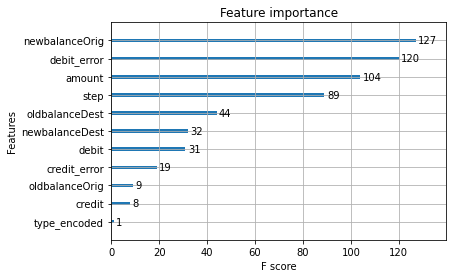

In [22]:
from xgboost import plot_importance
plot_importance(model)

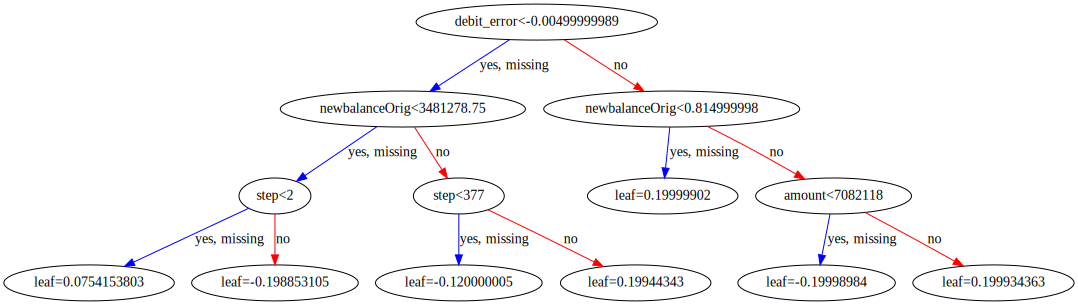

In [23]:
from xgboost import to_graphviz
to_graphviz(model)

In [24]:
import pickle
file_name = "xgb_v1.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
model_loaded = pickle.load(open(file_name, "rb"))

In [25]:
model_loaded.predict(pd.DataFrame(inp)),model.predict_proba(pd.DataFrame(inp))

(array([0]), array([[9.9984998e-01, 1.5002312e-04]], dtype=float32))